![](https://www.iberdrola.com/wcorp/gc/prod/pt_BR/comunicacion/machine_learning_mult_1_res/machine_learning_746x419.jpg)

### Table of Contents

1. [Introduction](#1.-Introduction)

2. [Base Libraries](#2.-Base-Libraries)

3. [Data Preprocessing](#3.-Data-Preprocessing)

4. [Feature Selection](#4.-Feature-Selection)

5. [Conclusions](#5.-Conclusions)

6. [References](#6.-References)

# 1. Introduction

During my studies, I tried to find a good example (or notebook) about RReliefF (Relief for Regression). Unfortunately, I couldn't find anything that suited my needs, as there were many examples for Classification, and almost none for Regression. So, I decided to collaborate with the Kaggle community and create an example of how to use RReliefF. To achieve this goal, I used the sklearn_relief library (https://gitlab.com/moongoal/sklearn-relief)

Relief is an algorithm developed by Kira and Rendell in 1992 that takes a filter-method approach to feature selection that is notably sensitive to feature interactions. It was originally designed for application to binary classification problems with discrete or numerical features. Relief calculates a feature score for each feature which can then be applied to rank and select top scoring features for feature selection. 

Robnik-Šikonja and Kononenko propose further updates to ReliefF, making it appropriate for regression (RReliefF, the focus of this notebook)

# 2. Base Libraries

First, the basic libraries are imported: **pandas**, **matplotlib**, **seaborn**, **numpy** to Dataframes, Graphs and numeric operations; **MinMaxScaler** to normalize our data between 0 and 1, **train_test_split** to help split the dataset (usually 70% training/ 30% testing). We'll use **power_transform** to make data more Gaussian-like, **RandomForestRegressor** to wrap the RReliefF algorithm on the second example, and **sklearn_relief** for obvious reasons

In [1]:
!pip install sklearn_relief

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# Base Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Transformation
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.pipeline import Pipeline
# Feature Selection
import sklearn_relief as sr
# Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# 3. Data Preprocessing

The main focus of this kernel is the RReliefF algorithm, but let's spend some time on the data preprocessing, to make our job easier.

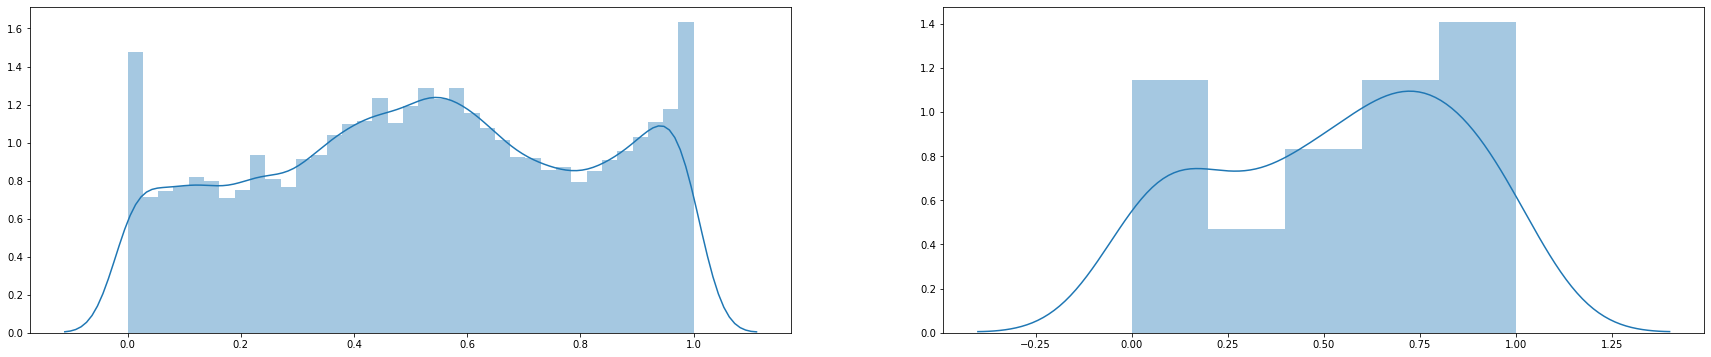

In [3]:
df_amp = pd.read_csv('../input/wind-power-generation/Amprion.csv')
dates = df_amp['Date']
df_amp = df_amp.T
df_amp = df_amp[1:]
df_amp.columns = [dates]

df_amp.reset_index(drop=True, inplace=True)

scaler = MinMaxScaler()

df_amp = power_transform(df_amp, method='yeo-johnson')
df_amp = scaler.fit_transform(df_amp)

X = df_amp[:,0:396]
y = df_amp[:,396]

# (optional) plot train & test
fig, ax=plt.subplots(1,2,figsize=(30, 6))
sns.distplot(X, ax=ax[0])
sns.distplot(y, ax=ax[1])



Here, the data will be imported, transposed so that we can use the days of the year as parameters, transformed using the **yeo-johnson** method and presented to see if they are resembling a Gaussian pattern.

# 4. Feature Selection

A large variety of feature selection methodologies have been proposed and research continues to support the claim that there is no universal “best” method for all tasks. In this section, the RReliefF is described in Filter and Wrapped Methods

## 4.1 Filter Method

This method uses a ‘proxy measure’ calculated from the general characteristics of the training data to score features or feature subsets as a processing step prior to modeling. Filters are generally **much faster and function independently** of the induction algorithm, meaning that selected features can then be passed to any modeling algorithm. Filter methods can be roughly classified further by the filtering measures they employ, i.e. information, distance, dependence, consistency, similarity, and statistical measures.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
r = sr.RReliefF(n_features = 20)
print(r.fit_transform(X_train,y_train))

[[0.89415851 0.36422555 0.62621622 ... 0.45517032 0.71635848 0.6717487 ]
 [0.67871428 0.48460741 0.74877678 ... 0.         0.83808516 0.32459573]
 [0.96491183 0.36422555 0.50591949 ... 0.56246492 0.655395   0.77543588]
 ...
 [0.77175778 0.54000668 0.56577229 ... 0.         0.83808516 0.2379575 ]
 [0.60169922 0.60478506 0.62621622 ... 0.17679116 0.63505834 0.2818013 ]
 [0.60169922 0.70105142 0.44668632 ... 0.24122983 0.51286805 0.44732296]]


Accordingly to the original implementation, a RReliefF used in filter method will rank all the features, based on importance. 

## 4.2 Wrapper Method

The best definition to this method: It **employs any stand-alone modeling algorithm to train a predictive model using a candidate feature subset**. The testing performance on a hold-out set is typically used to score the feature set. Alternatively in a modeling algorithm like a random forest (that I used in this example) , estimated feature importance scores can be applied to select a feature subset. In any wrapper method, a new model must be trained to test any subsequent feature subset, therefore wrapper methods are typically iterative and computationally intensive, but **can identify the best performing features set for that specific modeling algorithm**. Each iteration of the wrapper, the feature subset is generated based on the selected search strategy, e.g. forward or backward selection or a heuristic feature subset selection.

In [5]:
nof_list=np.arange(1,20)            
high_score=0
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    fs = sr.RReliefF(n_features = nof_list[n])
    relief = Pipeline([('fs', fs), ('m', RandomForestRegressor())])
    relief.fit(X_train,y_train)
    score = relief.score(X_test,y_test)
    score_list.append(score)
    print(f'NOF: {nof_list[n]}, Score: {score}')
    if(score > high_score):
        high_score = score
        nof = nof_list[n]

print (print(f'High Score: NOF: {nof}, Score: {high_score}'))

NOF: 1, Score: 0.27932192631210495
NOF: 2, Score: 0.8067238532284904
NOF: 3, Score: 0.8348164368593122
NOF: 4, Score: 0.8124319724040306
NOF: 5, Score: 0.8474549568954182
NOF: 6, Score: 0.9157598564164556
NOF: 7, Score: 0.8756264187735247
NOF: 8, Score: 0.8323628488343459
NOF: 9, Score: 0.8398673745530933
NOF: 10, Score: 0.8764731102720663
NOF: 11, Score: 0.7998208214099225
NOF: 12, Score: 0.8763158290958883
NOF: 13, Score: 0.8464276299034257
NOF: 14, Score: 0.8944675569202869
NOF: 15, Score: 0.8703602147095988
NOF: 16, Score: 0.8587723558021587
NOF: 17, Score: 0.874746504302209
NOF: 18, Score: 0.876438617106388
NOF: 19, Score: 0.8066324211755413
High Score: NOF: 6, Score: 0.9157598564164556
None


In this case, I wrapped the RReliefF algorithm in an Random Forest Regressor pipeline. The RF hyperparametrization wasn't done, but of course it can be used to improve even more the accuracy of this model. Here, the model is tested with n between 1 and 20 features, giving us the best values for this dataset.

## 5. Conclusions

Accordinly to the original paper, RReliefF can **discover strong dependencies between attributes**, while in domains without such dependencies it **performs the same as the mean squared error**. It is also robust and noise tolerant. Its intrinsic contextual nature allows it to recognize contextual attributes. From paper's original experimental results, it's concluded that learning regression trees with RReliefF is promising especially in combination with linear models in the leaves of the tree.

## 6. References

[1] Bolon-Canedo, V., Sanchez-Marono, N., Alonso-Betanzos, A., 2013. A Review of Feature Selection
Methods on Synthetic data. Knowledge and Information Systems 34 (3), 483–519.

[2] Dash, M., Liu, H., 1997. Feature Selection for Classification. Intelligent Data Analysis 1 (1-4), 131–156.

[3] Guyon, I., Elisseeff, A., 2003. An Introduction to Variable and Feature Selection. Journal of Machine
Learning Research 3 (Mar), 1157–1182.

[4] Holland, J. H., 1992. Adaptation in Natural and Artificial Systems. 1975. Ann Arbor, MI: University
of Michigan Press.

[5] Jovic, A., Brkic, K., Bogunovic, N., 2015. A Review of Feature Selection Methods with Applications. In: Information and Communication Technology, Electronics and Microelectronics (MIPRO), 2015 38th
International Convention on. IEEE, pp. 1200–1205.

[6] Kira, Kenji and Rendell, Larry (1992). The Feature Selection Problem: Traditional Methods and a New Algorithm. AAAI-92 Proceedings.

[7] Kira, Kenji and Rendell, Larry (1992) A Practical Approach to Feature Selection, Proceedings of the Ninth International Workshop on Machine Learning, p249-256

[8] Kittler, J., 1978. Feature set Search algorithms. Pattern Recognition and Signal Processing.

[9] Langley, P., 1994. Selection of Relevant Features in Machine Learning. In: Proceedings of the AAAI Fall Symposium on Relevance. Vol. 184. pp. 245–271

[10] Menze, B. H., Kelm, B. M., Masuch, R., Himmelreich, U., Bachert, P., Petrich, W., Hamprecht, F. A., 2009. A Comparison of Random Forest and its Gini Importance with Standard Chemometric Methods for the Feature Selection and Classification of Spectral Data. BMC Bioinformatics 10 (1), 213

[11] Ni, W., 2012. A Review and Comparative Study on Univariate Feature Selection Techniques. Ph.D. thesis, University of Cincinnati.

[12] Robnik-Šikonja, Marko, and Kononenko, Igor (1997). An Adaptation of Relief for Attribute Estimation in Regression. Machine Learning: Proceedings of the Fourteenth International Conference (ICML’97) (p296-304)

[13] Van Laarhoven, P. J., Aarts, E. H., 1987. Simulated Annealing. In: Simulated Annealing: Theory and
Applications. Springer, pp. 7–15.